# Capstone Project: Grab Challenge(Traffic Management)

# 1. Introduction

In Eskwelabs, we were tasked to complete a capstone project of our interest. I chose to take on the Grab challenge on Traffic Management. The main goal of this challenge is to accurately predict travel demand for each location

<img src="https://s3.amazonaws.com/carmudi-blogs/carmudi-ph/wp-content/uploads/2018/12/31192909/117.jpg">

# 2. Problem statement and hypothesis

Although Grab had given its main goal of predicting the demand, I was curious on WHY they wanted to predict demand.

From reading more on Grab's operations in the Philippines, I was able to learn that:
- Since Uber withdrew their operations in the country, there has been a limited number of allowed TNVS to operate. This is due to LTFRB's requirement to update the master list of Grab TNVS before operation.
- With this, Grab Philippines is limited by its supply of cars. Ever since Uber closed, they have been shouldering the same travel demand for ride-hailing services with their limited supply.
- From basic economics, we realize that prices must be raised to accommodate a large demand with low supply. This is what Grab Philippines has done.

However, this would leave customers dissatisfied since the increase in prices do not necessarily show the improvement in the quality of service (since the supply is still limited).

This leads us to the main problem

**How do we improve the service quality of Grab Philippines' ride-hailing services with the  limitation of the availability of cars?**

To do this, I first needed to understand travel patterns within an area, so I asked these three questions

1. Where is the travel demand high?
2. When is the travel demand high?
3. and What model could I use to predict travel demand

## By knowing the answers to these questions, these sectors could also benefit
  - Government
    - They can observe which areas are in need of infrastructural development to ease traffic congestion
    - Allow them to create or mandate rules and laws, such as vehicle coding for specific areas
    - Deploy more MMDA traffic enforcers to make traffic management more bearable
  - Community
    - Knowing travel patterns would allow people to forsee travel time so they could avoid being late


# 3. Description of your data set and how it was obtained

I used the data set in the Grab Challenge on Traffic Management.

Which can be accessed through this link: https://www.aiforsea.com/traffic-management

<img src="https://vectorlogo4u.com/wp-content/uploads/2018/09/grqab-vector-logo-720x340.png">




<h3> GOAL of GRAB CHALLENGE</h3>

"In this challenge, participants are to build a model trained on a historical demand dataset, that can forecast demand on a Hold-out test dataset. The model should be able to accurately forecast ahead by T+1 to T+5 time intervals (where each interval is 15-min) given all data up to time T."

# 4. Data Preparation

In [0]:
# Import geohash
from google.colab import files
uploaded = files.upload()

Saving geohash.py to geohash.py


In [0]:
import pandas as pd
from datetime import datetime,timedelta

import geohash as gh
from math import sin, cos, radians, atan2,sqrt
import statsmodels.api as sm
import numpy as np

#Visualization
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

## Importing Dataframes

The 'training.csv' file was available on the Grab site. This is the *df* dataframe. The other CSV files are processed forms of the *df* dataframe for easy access.

In [0]:
#Import files needed
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#Unprocessed
link = "https://drive.google.com/open?id=19QeoYrLRgTXRdWE0Lp2ajmbdH3_agFLb"

fluff, id = link.split('=')

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('training.csv')  
df = pd.read_csv('training.csv')

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exceptio

In [0]:
# Averaged All Locs
link = "https://drive.google.com/open?id=1GybXPHhtnlT1bBpg5CFoMhhu2upF--5f"

fluff, id = link.split('=')

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Averaged_All_Locs.csv')  
df_ave = pd.read_csv('Averaged_All_Locs.csv')

INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/drive/v2/files/1GybXPHhtnlT1bBpg5CFoMhhu2upF--5f?alt=json


In [0]:
link = "https://drive.google.com/open?id=1cRz-tjnMB5JyOera3kij_09-P09eXPbF"

fluff, id = link.split('=')

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Analysis_Univariate.csv')  
df_uni = pd.read_csv('Analysis_Univariate.csv')
# Dataset is now storaed in a Pandas Dataframe

INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/drive/v2/files/1cRz-tjnMB5JyOera3kij_09-P09eXPbF?alt=json


In [0]:
# using offline

df = pd.read_csv('Processed_Grab.csv')
df_uni = pd.read_csv('Analysis_Univariate.csv')
df_ave = pd.read_csv('Averaged_All_Locs.csv')

# Pre-Processing

Since the data only contained raw, unusable data for time-series analysis, I first pre-processed the data. These are the steps I did

In [0]:
df.dtypes

geohash6      object
day            int64
timestamp     object
demand       float64
dtype: object

In [0]:
df.shape

(4206321, 4)

In [0]:
df.describe()

,day,demand
count,4.206321e+06,4.206321e+06
mean,3.145299e+01,1.050907e-01
std,1.768278e+01,1.592655e-01
min,1.000000e+00,3.092217e-09
25%,1.600000e+01,1.867379e-02
50%,3.200000e+01,5.043463e-02
75%,4.700000e+01,1.208644e-01
max,6.100000e+01,1.000000e+00


In [0]:
df.head()

,geohash6,day,timestamp,demand
0,qp03wc,18,20:0,0.020072
1,qp03pn,10,14:30,0.024721
2,qp09sw,9,6:15,0.102821
3,qp0991,32,5:0,0.088755
4,qp090q,15,4:0,0.074468


## Convert geohash6 to latitude and longitude
Here we first decode the geohash given into latitude and longitude

In [0]:
#Decode geohash to Latitude and Longitude
df['lat_long'] = df.geohash6.apply(lambda x: gh.decode(x))

In [0]:
df['latitude'] = df.lat_long.apply(lambda x: x[0])
df['longitude'] = df.lat_long.apply(lambda x: x[1])

In [0]:
df.drop(columns='lat_long',inplace=True)

## Set arbitrary day of the week
Since Grab did not give the specific dates in their data set, we first set arbitrary labels to the day of the week

In [0]:
#Since the data for day is in sequential order, we assign an arbitrary 
def day_week(day):
    if day%7 == 1: return "A"
    elif day%7 == 2: return "B"
    elif day%7 == 3: return "C"
    elif day%7 == 4: return "D"
    elif day%7 == 5: return "E"
    elif day%7 == 6: return "F"
    else: return "G"

df['day_of_week'] = df.day.apply(lambda x: day_week(x))

## Make 'day' and 'timestamp' a timestamp

Set arbitrary dates to the days as well

In [0]:
numdays = 61
base = datetime(2019,1,1,0,0)
date_list = [base + timedelta(days=x) for x in range(0, numdays)]

df.day = df.day.apply(lambda x: date_list[x-1].strftime("%Y-%m-%d"))

In [0]:
TS = []
for i in range(0,len(df.day)):
    x = pd.Timestamp(df.day[i] + ' ' + df.timestamp[i])
    TS.append(x)

In [0]:
df['Timestamp'] = TS

In [0]:
df = df.drop(columns = ['day','timestamp'])

In [0]:
df.head()

,geohash6,demand,latitude,longitude,day_of_week,Timestamp
0,qp03wc,0.020072,-5.353088,90.653687,D,2019-01-18 20:00:00
1,qp03pn,0.024721,-5.413513,90.664673,C,2019-01-10 14:30:00
2,qp09sw,0.102821,-5.325623,90.906372,B,2019-01-09 06:15:00
3,qp0991,0.088755,-5.353088,90.752563,D,2019-02-01 05:00:00
4,qp090q,0.074468,-5.413513,90.719604,A,2019-01-15 04:00:00


In [0]:
df.dtypes

geohash6               object
demand                float64
latitude              float64
longitude             float64
day_of_week            object
Timestamp      datetime64[ns]
dtype: object

## Final Processed Dataframe

Essentially, the resulting dataframe above was saved into a CSV file.

The file is accessed here so that the pre-processing steps need not be run repeatedly.

In [0]:
# Processed Grab
link = "https://drive.google.com/open?id=18t-ZOhc067NLj9RmlBTNuA97tX_B9VcT"

fluff, id = link.split('=')

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Processed_Grab.csv')  
df = pd.read_csv('Processed_Grab.csv')

INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/drive/v2/files/18t-ZOhc067NLj9RmlBTNuA97tX_B9VcT?alt=json


In [0]:
df.Timestamp = df.Timestamp.apply(lambda x: pd.Timestamp(x))

In [0]:
df.drop(columns = ['Unnamed: 0'],inplace = True)

In [0]:
df.head()

,geohash6,demand,latitude,longitude,day_of_week,Timestamp
0,qp03wc,0.020072,-5.353088,90.653687,D,2019-01-18 20:00:00
1,qp03pn,0.024721,-5.413513,90.664673,C,2019-01-10 14:30:00
2,qp09sw,0.102821,-5.325623,90.906372,B,2019-01-09 06:15:00
3,qp0991,0.088755,-5.353088,90.752563,D,2019-02-01 05:00:00
4,qp090q,0.074468,-5.413513,90.719604,A,2019-01-15 04:00:00


In [0]:
df.dtypes

geohash6               object
demand                float64
latitude              float64
longitude             float64
day_of_week            object
Timestamp      datetime64[ns]
dtype: object

# 5. Exploratory Data Analysis

## Distribution of Demand

From here we see that the values are skewed towards 0 with only an extremely small spike in 1. This means that in a general area there are more locations with no travel demand for Grab at all.

The distribution of demand is skewed towards 0 is also the reason why I chose to fill the missing data as 0 for missing travel demand for certain times of certain locations.

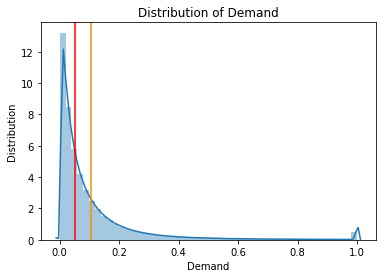

In [0]:
sns.distplot(df['demand'])
plt.title('Distribution of Demand')
plt.ylabel('Distribution')
plt.xlabel('Demand')
plt.axvline(df.demand.mean(), color='darkorange')
plt.axvline(df.demand.median(), color='red')
plt.show()

I also wanted to look at the average demand per day and it seems that there are only 3 days thaat go beyond the mean demand (these are Wednesday, Thursday, and Friday). So, generally, we need suggest to Grab that they need more drivers online on these days.

Text(0.5, 1.0, 'Average Demand per Day of the Week')

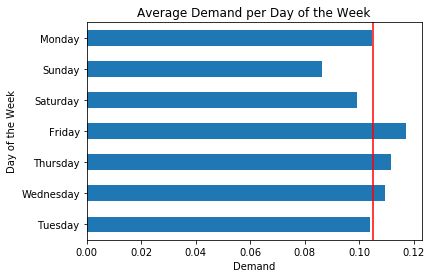

In [0]:
df.groupby('day_of_week')['demand'].mean().plot.barh()
plt.axvline(df.demand.mean(), color='red')
plt.yticks(np.arange(7),['Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','Monday'])
plt.ylabel('Day of the Week')
plt.xlabel('Demand')
plt.title('Average Demand per Day of the Week')

## Average demand for all locations

(array([737057., 737060., 737067., 737074., 737081., 737088., 737091.,
        737098., 737105., 737112., 737119.]),
 <a list of 11 Text xticklabel objects>)

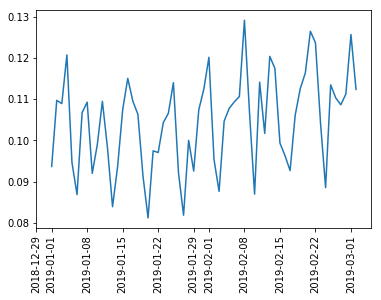

In [0]:
plt.plot(df.groupby(pd.DatetimeIndex(df['Timestamp']).normalize())['demand'].mean())
plt.xticks(rotation='vertical')

## Average Hourly demand for Day of the Week

In [0]:
df_day = pd.pivot_table(df ,values = 'demand', index = ['geohash6','day_of_week'], columns = ['Timestamp'],fill_value=0).reset_index()

df_day = df_day.groupby('day_of_week').aggregate('mean')

df_day = df_day.T

df_day.reset_index(inplace=True)

df_day = df_day.groupby(df_day['Timestamp'].dt.hour).mean()

In [0]:
## From initially plotting the average hourly demand for each day of the week, I saw that F had the lowest demand
## I confidently assumed this was Sunday because it is consistent with what occurs in real life, that travel is lowest on Sundays 
## and that the other days also have consistent behaviour

df_day = df_day[['F','G','A','B','C','D','E']]

In [0]:
df_day.head()

day_of_week,F,G,A,B,C,D,E
Timestamp,,,,,,,
0,0.003543,0.008902,0.009138,0.010529,0.009978,0.009382,0.005853
1,0.005100,0.009573,0.010129,0.011449,0.010892,0.010554,0.007545
2,0.006579,0.009289,0.010201,0.010994,0.010668,0.010940,0.009060
3,0.007571,0.010128,0.011062,0.011584,0.011404,0.012146,0.010446
4,0.008517,0.011093,0.012411,0.012773,0.012621,0.014313,0.011747


In [0]:
from matplotlib.lines import Line2D

def plot_days(ts_w):
    
    plt.figure(figsize=(10,5))
    
    for wd in range(0, 7):
        x_vals = ts_w.index
        y_vals = ts_w.iloc[:,[wd]]
        
        plt.plot(x_vals, y_vals, lw=3, label=wd, linewidth=3)
        
    plt.legend(['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'], loc='best',fontsize=15)
    plt.xlabel('Hour',fontsize=20)
    plt.ylabel('Demand',fontsize=20)
    plt.xticks(x_vals, x_vals,fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlim((0, 23))
    plt.ylim(ymin=0)

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


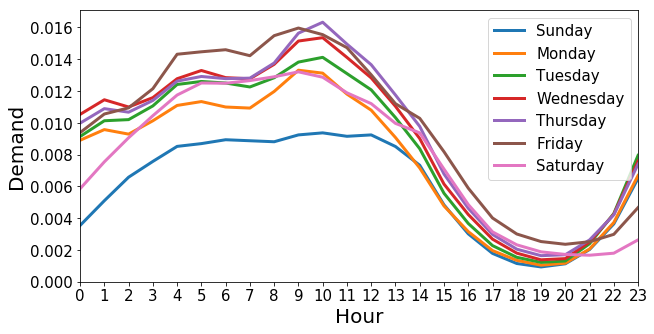

In [0]:
plot_days(df_day)

In [0]:
del df_day

## General Trend

From plotting the average hourly demand per day, we see that we can't have a daily seasonality because the travel demand pattern varies for each day. Thus we use a weekly seasonality which is calculated by (7days/1week)(24hrs/day)(60min/hr)/(15min intervals) = 672 [data points/week]

In [0]:
df_trend = df.groupby('Timestamp').agg({'demand':'mean'})

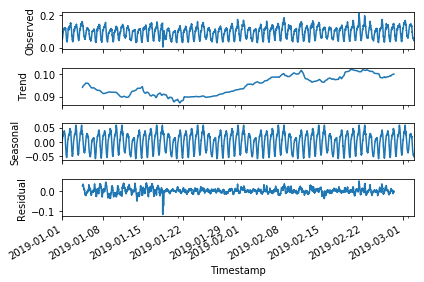

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_trend, model='additive',freq=672)
result.plot()
plt.show()

In [0]:
df_tl = result.trend.dropna()

x = range(0,len(df_tl))
y = df_tl.demand
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

df_tl['z'] = p(x)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


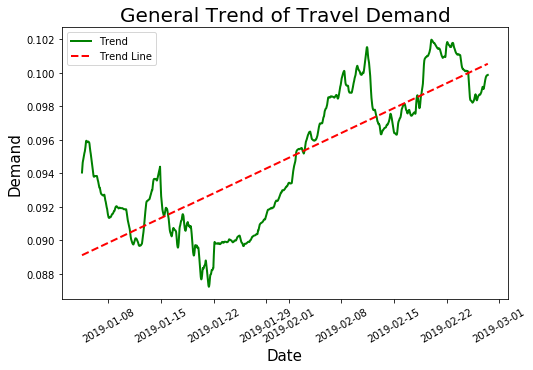

In [0]:
plt.figure(figsize=(8,5))
plt.plot(df_tl.index,df_tl.demand, c='green',linewidth=2)
plt.plot(df_tl.index,df_tl.z,"r--", linewidth=2)
plt.xlabel('Date',fontsize = 15)
plt.ylabel('Demand',fontsize = 15)
plt.xticks(rotation = 30,fontsize = 10)
plt.yticks(fontsize = 10)
plt.title('General Trend of Travel Demand',fontsize = 20)
plt.legend(['Trend','Trend Line'], loc='best',fontsize=10)

In [0]:
print('EQN OF LINE: y = '+ str(z[0]) + 'x + ' + str(z[1]))

EQN OF LINE: y = 2.2095675282556675e-06x + 0.08911181887179445


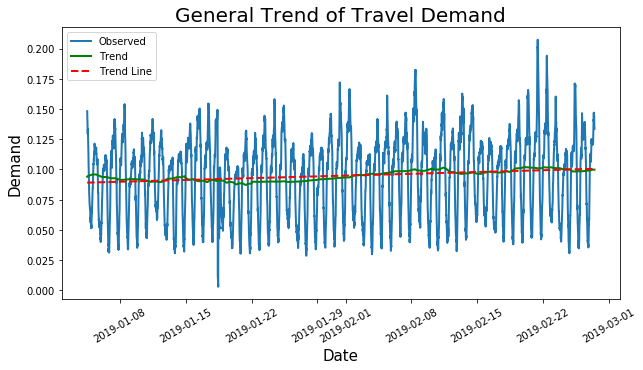

In [0]:
plt.figure(figsize=(10,5))
plt.plot(df_tl.index,result.observed.loc[df_tl.index.values], linewidth=2)
plt.plot(df_tl.index,df_tl.demand, c='green',linewidth=2)
plt.plot(df_tl.index,df_tl.z,"r--", linewidth=2)
plt.xlabel('Date',fontsize = 15)
plt.ylabel('Demand',fontsize = 15)
plt.xticks(rotation = 30,fontsize = 10)
plt.yticks(fontsize = 10)
plt.title('General Trend of Travel Demand',fontsize = 20)
plt.legend(['Observed','Trend','Trend Line'], loc='best',fontsize=10)

In [0]:
del df_tl

## Finding Hotspots (Look for areas with high average demand)

In [0]:
df_uniq = df.groupby('geohash6')['demand'].mean().sort_values(ascending=False)

df_uniq = df_uniq.reset_index()

df_uniq['lat_long'] = df_uniq.geohash6.apply(lambda x: gh.decode(x))

df_uniq['latitude'] = df_uniq.lat_long.apply(lambda x: x[0])

df_uniq['longitude'] = df_uniq.lat_long.apply(lambda x: x[1])

df_uniq.drop(columns='lat_long',inplace=True)

Text(0, 0.5, 'Longitude')

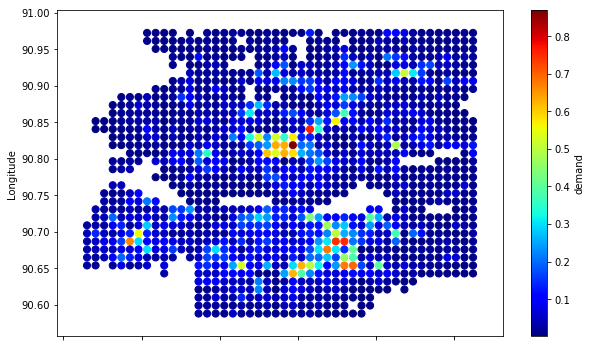

In [0]:
df_uniq.plot.scatter('latitude', 'longitude', c='demand', colormap='jet', s=50,figsize=(10,6))

plt.xlabel('Latitude')
plt.ylabel('Longitude')

In [0]:
del df_uniq

## Animate Through Time

### Average Demand per Hour

In [0]:
df_ani = df.sort_values('Timestamp')

df_ani = pd.pivot_table(df_ani ,values = 'demand', columns= 'geohash6', index = 'Timestamp', fill_value= 0)

#df_ani = df_ani.groupby(pd.DatetimeIndex(df_ani.index).normalize()).agg('mean')
df_ani = df_ani.groupby(df_ani.index.hour).agg('mean')

df_ani = df_ani.T

df_ani.reset_index(inplace = True)

df_ani['lat_long'] = df_ani.geohash6.apply(lambda x: gh.decode(x))

df_ani['latitude'] = df_ani.lat_long.apply(lambda x: x[0])

df_ani['longitude'] = df_ani.lat_long.apply(lambda x: x[1])

df_ani.drop(columns = ['lat_long'],inplace = True)

<IPython.core.display.Javascript object>


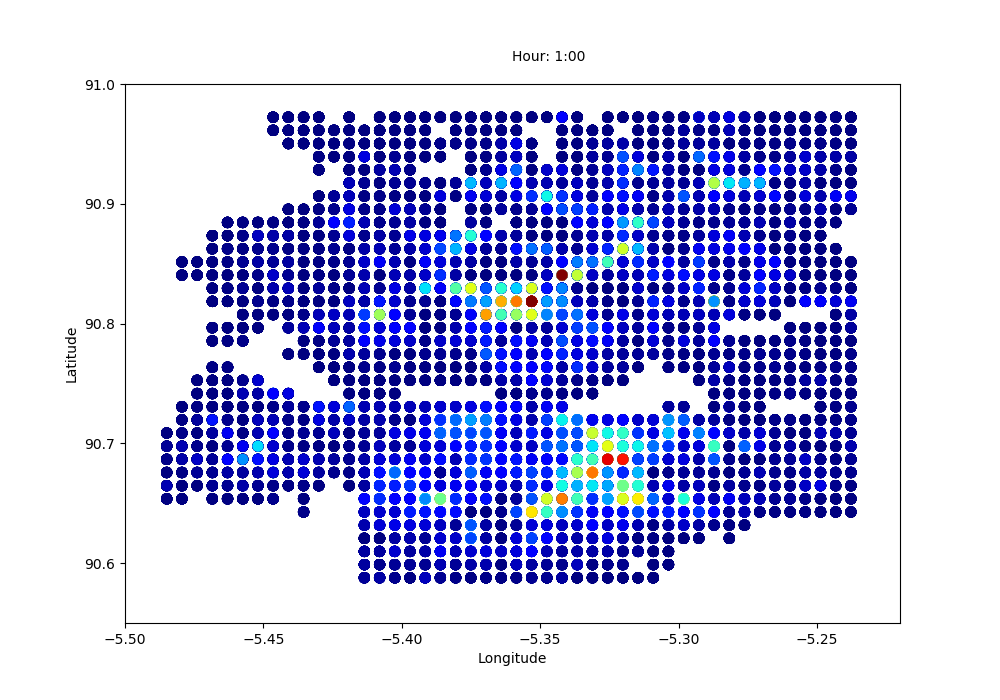

In [0]:
import matplotlib
import matplotlib.animation as animation
#matplotlib.use('Agg')
%matplotlib notebook


# Initialize Values
long = list(df_ani['longitude'])
lat = list(df_ani['latitude'])

# Initialize Figure
fig, ax = plt.subplots(figsize=(10,7))
ax.set_xlim(-5.5, -5.22)
ax.set_xlabel('Longitude',fontsize=10)
ax.set_ylim(90.55 , 91)
ax.set_ylabel('Latitude',fontsize=10)
#ax.set_title('Daily changes in Travel Demand',fontsize=10)
ttl = ax.text(.5, 1.05, '', transform = ax.transAxes, va='center',fontsize=10)

# Animate
def animate(i):
    ttl.set_text('Hour: '+str(i)+':00')
    scat = ax.scatter(lat,long,c=list(df_ani[i]),cmap='jet', s=50)
    return scat,ttl

def init():
    return []

anim=animation.FuncAnimation(fig,animate,frames=24,interval=400,init_func=init,repeat=True)
anim.save('animation.gif', writer='imagemagick', fps=2)
plt.show()    

### Demand for Day 1

In [0]:
df_ani = df.sort_values('Timestamp')

df_ani = pd.pivot_table(df_ani ,values = 'demand', columns= 'geohash6', index = 'Timestamp', fill_value= 0)

df_ani = df_ani['2019-01-01']

In [0]:
df_ani = df_ani.T

df_ani.reset_index(inplace = True)

df_ani['lat_long'] = df_ani.geohash6.apply(lambda x: gh.decode(x))

df_ani['latitude'] = df_ani.lat_long.apply(lambda x: x[0])

df_ani['longitude'] = df_ani.lat_long.apply(lambda x: x[1])

df_ani.drop(columns = ['lat_long'],inplace = True)

<IPython.core.display.Javascript object>


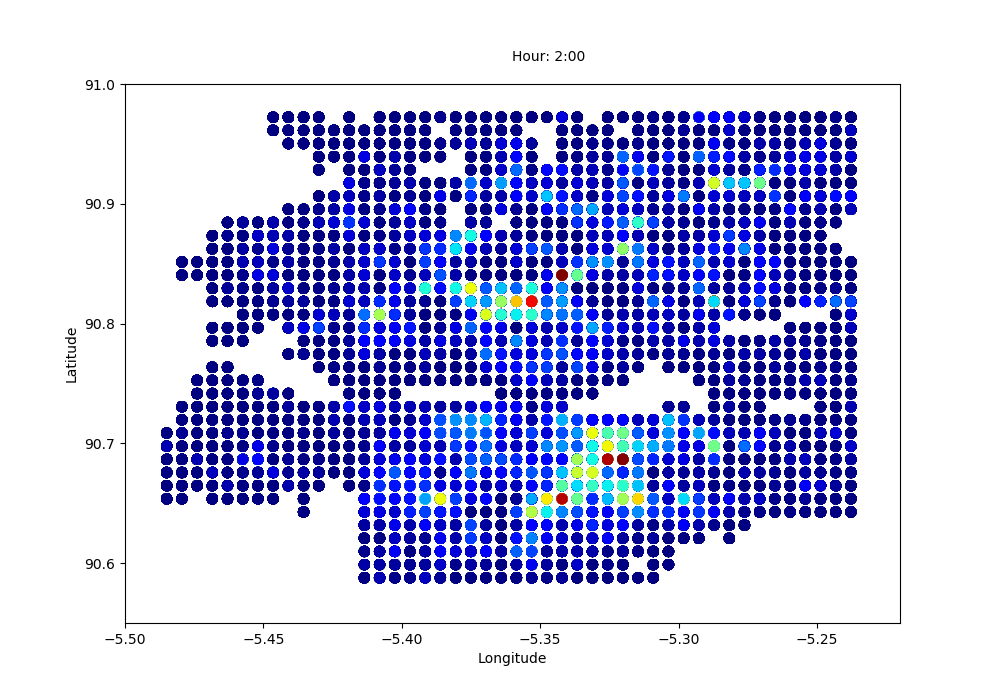

In [0]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Initialize Values
long = list(df_ani['longitude'])
lat = list(df_ani['latitude'])

# Initialize Figure
fig, ax = plt.subplots(figsize=(10,7))
ax.set_xlim(-5.5, -5.22)
ax.set_xlabel('Longitude',fontsize=10)
ax.set_ylim(90.55 , 91)
ax.set_ylabel('Latitude',fontsize=10)
#ax.set_title('Daily changes in Travel Demand',fontsize=10)
ttl = ax.text(.5, 1.05, '', transform = ax.transAxes, va='center',fontsize=10)

# Animate
def animate(i):
    ttl.set_text(str(df_ani.columns[i+1]))
    scat = ax.scatter(lat,long,c=list(df_ani.iloc[:,i+1]),cmap='jet', s=50)
    return scat,ttl

def init():
    return []

anim=animation.FuncAnimation(fig,animate,frames=96,interval=200,init_func=init)
anim.save('animation_min.gif', writer='imagemagick', fps=16)

plt.show()    

In [0]:
del df_ani

# Initializing Metrics used

In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_actual, y_predicted, print_val=True):
    """
    Args:
    -----
    y_actual - Array of actual target values
    y_predicted - Array of predicted target values
    print_val - If `True` (default), RMSE will be
                printed. O
                therwise, it will be 
                returned.
    """
    err = sqrt(mean_squared_error(y_actual, y_predicted))
    if print_val:
        print('RMSE: {:,.2f}'.format(err))
    else:
        return err
      
def percent_error(y_actual, y_predicted, print_val=True):
    """
    percent_error is RMSE divided by sum of actual
    rides
    
    Args:
    -----
    y_actual - Array of actual target values
    y_predicted - Array of predicted target values
    print_val - If `True` (default), percent error will be
                printed. Otherwise, it will be 
                returned.
    """
    err = rmse(y_actual, y_predicted, print_val=False)
    err = float(err)/np.mean(y_actual)
    # err = np.mean(np.abs(np.subtract(list(actuals), list(pred.yhat))))/np.mean(actuals)
    
    if print_val:
        print('RMSE/daily_mean: {:,.2%}'.format(err))
    else:
        return err
    
def plot_forecast(actual, pred, title='Actual vs Forecast', 
                  xlabel='Date', ylabel='Demand', 
                  grid=True, figsize=(30, 9)):
    
    if len(actual) != len(pred):
        return_str = 'Unequal lengths error: '
        return_str += '({} actual, '.format(len(actual))
        return_str += '{} forecast)'.format(len(pred))
        return return_str
    
    plt.figure(figsize=figsize)
    plt.plot(actual, label='Actual', linewidth=2)
    plt.plot(actual.index, pred, label='Predicted', c='r', linewidth=2)
    #plt.title(title)
    plt.xlabel(xlabel,fontsize = 25)
    plt.ylabel(ylabel,fontsize = 25)
    plt.xticks(actual.index.date[::24], 
               actual.index.day[::24],fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.xlim(min(actual.index.date), max(actual.index.date))
    plt.legend(loc='best',fontsize = 20)
    plt.grid(True)

# 6. FBProphet on Average Demand for All Locations

Before using FBprophet to predict the demand for each location, I would like to try predicting the average demand for all locations first

## Install necessary modules

In [0]:
!pip install Cython

In [0]:
!pip install pystan

In [0]:
!pip install fbprophet

## Set dataframe

In [0]:
df_prophet = df_ave.copy(deep=True)

In [0]:
del df_ave

In [0]:
df_prophet.Timestamp = df_prophet.Timestamp.apply(lambda x: pd.Timestamp(x))

df_prophet.rename(columns={'Timestamp':'ds','demand':'y'}, inplace = True)

df_prophet.sort_values('ds',inplace=True)

In [0]:
df_prophet.head()

,ds,y
0,2019-01-01 00:00:00,0.022744
1,2019-01-01 00:15:00,0.025120
2,2019-01-01 00:30:00,0.027232
3,2019-01-01 00:45:00,0.029258
4,2019-01-01 01:00:00,0.033303


In [0]:
df_prophet.shape

(5847, 2)

## Train Test Split

In [0]:
df_train = df_prophet.iloc[:4791]
df_test = df_prophet.iloc[4791:]

In [0]:
# From January 1 to Feb 19 (50 days)
df_train.tail(3)

,ds,y
4788,2019-02-19 23:15:00,0.050087
4789,2019-02-19 23:30:00,0.057703
4790,2019-02-19 23:45:00,0.062066


In [0]:
df_test.set_index('ds',inplace=True)

In [0]:
# Feb 20 to March 2 (11 days)
df_test.tail(3)

,y
ds,
2019-03-02 23:15:00,0.018111
2019-03-02 23:30:00,0.021290
2019-03-02 23:45:00,0.023138


In [0]:
df_test.shape

(1152, 1)

## Create and Fit Model

In [0]:
from fbprophet import Prophet

m = Prophet(yearly_seasonality=False,changepoint_prior_scale=0.01)
m.fit(df_train);

In [0]:
future = m.make_future_dataframe(periods=1056, freq='15Min')
forecast = m.predict(future)

In [0]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-01 00:00:00,0.055024,0.034209,0.060757,0.055024,0.055024,-0.008041,-0.008041,-0.008041,-0.007763,-0.007763,-0.007763,-0.000278,-0.000278,-0.000278,0.0,0.0,0.0,0.046982
1,2019-01-01 00:15:00,0.055022,0.036254,0.063358,0.055022,0.055022,-0.005208,-0.005208,-0.005208,-0.004898,-0.004898,-0.004898,-0.000310,-0.000310,-0.000310,0.0,0.0,0.0,0.049814
2,2019-01-01 00:30:00,0.055020,0.039360,0.065862,0.055020,0.055020,-0.002544,-0.002544,-0.002544,-0.002202,-0.002202,-0.002202,-0.000342,-0.000342,-0.000342,0.0,0.0,0.0,0.052476
3,2019-01-01 00:45:00,0.055018,0.042577,0.068662,0.055018,0.055018,-0.000062,-0.000062,-0.000062,0.000311,0.000311,0.000311,-0.000373,-0.000373,-0.000373,0.0,0.0,0.0,0.054957
4,2019-01-01 01:00:00,0.055017,0.044081,0.070494,0.055017,0.055017,0.002234,0.002234,0.002234,0.002637,0.002637,0.002637,-0.000403,-0.000403,-0.000403,0.0,0.0,0.0,0.057251


Text(0.5, 1.0, 'Prophet - Model fit and the 12-day prediction')

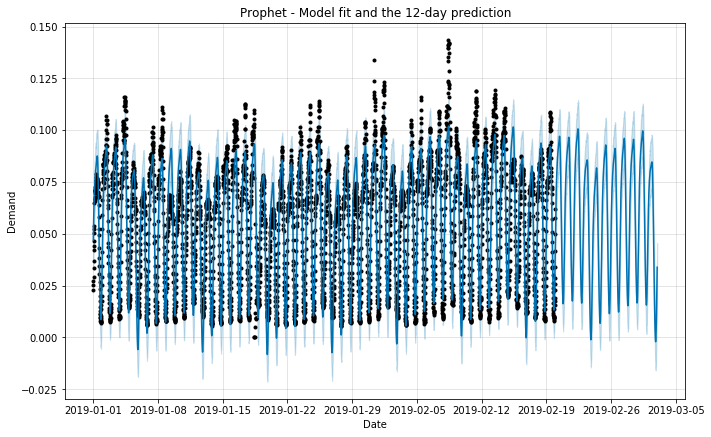

In [0]:
m.plot(forecast, xlabel='Date', ylabel='Demand')
plt.title('Prophet - Model fit and the 12-day prediction')

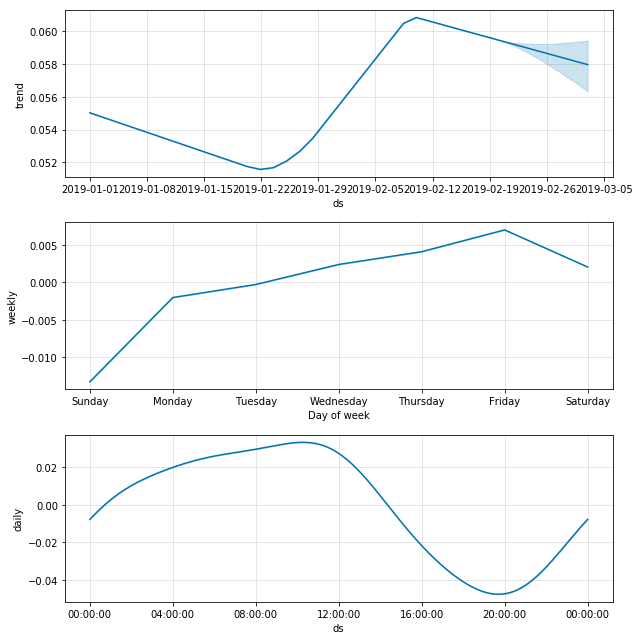

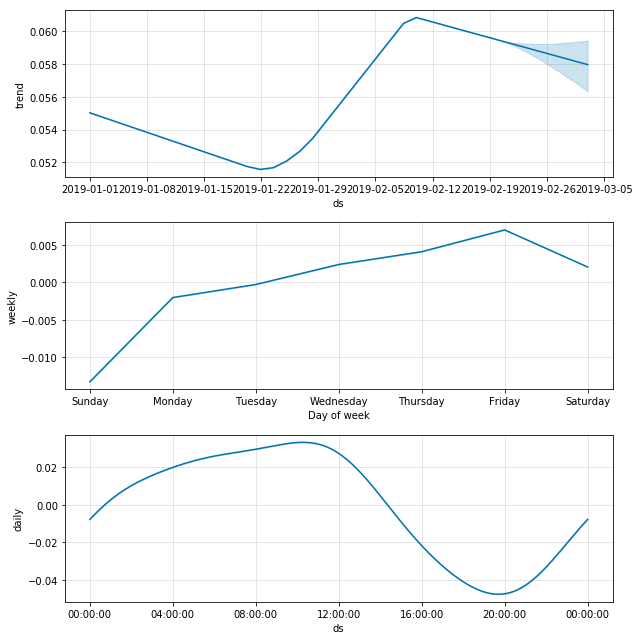

In [0]:
m.plot_components(forecast)

In [0]:
pred = forecast[['ds', 'yhat']][4791:].copy()

In [0]:
pred.set_index('ds',inplace=True)

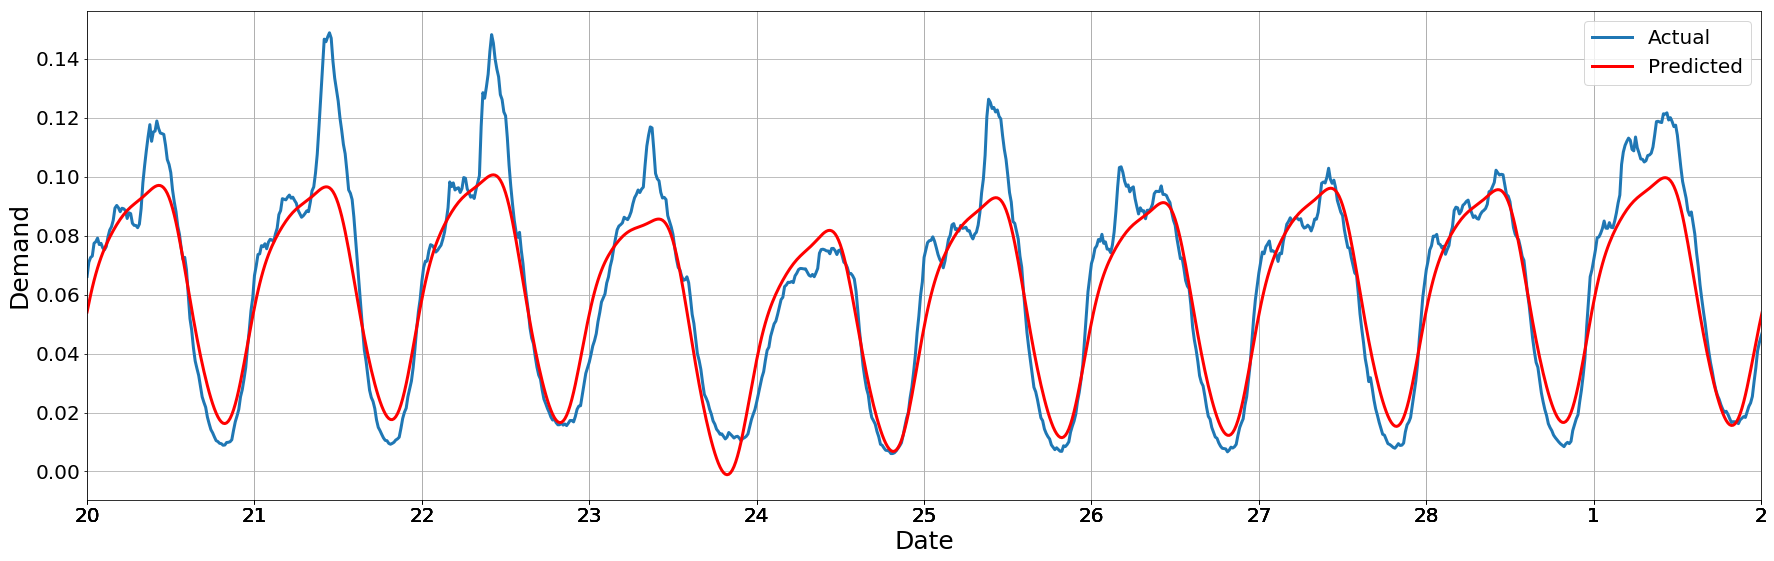

In [0]:
plot_forecast(df_test.y, pred)

In [0]:
rmse(df_test.y, pred)

RMSE: 0.01


# 7. Time-Series Analysis Models for predicting future demand for  each location

In the interest of time and my laptop's specs, I was only able to predict the travel demand for the top 100 locations with the highest average demand.

## Data Preparation

In [0]:
df_uniq = df.groupby('geohash6')['demand'].mean().sort_values(ascending=False)

df_uniq = df_uniq.reset_index()

df_uniq['lat_long'] = df_uniq.geohash6.apply(lambda x: gh.decode(x))

df_uniq['latitude'] = df_uniq.lat_long.apply(lambda x: x[0])

df_uniq['longitude'] = df_uniq.lat_long.apply(lambda x: x[1])

df_uniq.sort_values('demand',ascending=False,inplace=True)

df_top = df_uniq.head(100)

df_bottom = df_uniq.tail(100)

In [0]:
del df_uniq

In [0]:
df_top.head(3)

,geohash6,demand,lat_long,latitude,longitude
0,qp09d9,0.869152,"(-5.35308837890625, 90.8184814453125)",-5.353088,90.818481
1,qp09e5,0.761055,"(-5.34210205078125, 90.8404541015625)",-5.342102,90.840454
2,qp03xx,0.753067,"(-5.32012939453125, 90.6866455078125)",-5.320129,90.686646


In [0]:
df_bottom.head(3)

,geohash6,demand,lat_long,latitude,longitude
1229,qp08gs,0.006731,"(-5.46844482421875, 90.8624267578125)",-5.468445,90.862427
1230,qp09fc,0.006711,"(-5.30914306640625, 90.8294677734375)",-5.309143,90.829468
1231,qp03zy,0.006710,"(-5.28167724609375, 90.6976318359375)",-5.281677,90.697632


In [0]:
df_uni['Timestamp'] = pd.to_datetime(df_uni['Timestamp'])
df_uni.rename(columns={'Timestamp':'ds'},inplace = True)
df_uni.set_index('ds',inplace=True)

In [0]:
df_top.lat_long = df_top.lat_long.apply(lambda s: str(s))

In [0]:
df_uni = df_uni[list(df_top.lat_long)]


In [0]:
df_uni.shape

(5847, 100)

## Train Test Split

In [0]:
df_train = df_uni[:'2019-02-19'].copy(deep = True)
df_test = df_uni['2019-02-20':].copy(deep = True)

In [0]:
df_train.head(3)

,"(-5.35308837890625, 90.8184814453125)","(-5.34210205078125, 90.8404541015625)","(-5.32012939453125, 90.6866455078125)","(-5.32562255859375, 90.6866455078125)","(-5.31463623046875, 90.6536865234375)","(-5.33111572265625, 90.6756591796875)","(-5.32012939453125, 90.6536865234375)","(-5.45745849609375, 90.6866455078125)","(-5.36407470703125, 90.8184814453125)","(-5.35858154296875, 90.8184814453125)","(-5.35858154296875, 90.8074951171875)","(-5.34759521484375, 90.6536865234375)","(-5.35308837890625, 90.6427001953125)","(-5.36956787109375, 90.8074951171875)","(-5.35308837890625, 90.8074951171875)","(-5.35308837890625, 90.8294677734375)","(-5.32562255859375, 90.8514404296875)","(-5.45196533203125, 90.6976318359375)","(-5.36407470703125, 90.8074951171875)","(-5.37506103515625, 90.8294677734375)","(-5.38604736328125, 90.6536865234375)","(-5.36407470703125, 90.8294677734375)","(-5.28167724609375, 90.9173583984375)","(-5.32562255859375, 90.6976318359375)","(-5.34210205078125, 90.6536865234375)","(-5.28717041015625, 90.8184814453125)","(-5.33111572265625, 90.7086181640625)","(-5.32012939453125, 90.6646728515625)","(-5.34210205078125, 90.7196044921875)","(-5.31463623046875, 90.6756591796875)","(-5.29815673828125, 90.6536865234375)","(-5.30364990234375, 90.7196044921875)","(-5.34759521484375, 90.6427001953125)","(-5.31463623046875, 90.6646728515625)","(-5.28717041015625, 90.6976318359375)","(-5.32012939453125, 90.8624267578125)","(-5.35858154296875, 90.8294677734375)","(-5.40802001953125, 90.8074951171875)","(-5.33660888671875, 90.8404541015625)","(-5.38055419921875, 90.8294677734375)",...,"(-5.29815673828125, 90.7196044921875)","(-5.33660888671875, 90.8514404296875)","(-5.39154052734375, 90.6536865234375)","(-5.35858154296875, 90.6427001953125)","(-5.32012939453125, 90.8843994140625)","(-5.33660888671875, 90.7196044921875)","(-5.36956787109375, 90.7196044921875)","(-5.32562255859375, 90.6536865234375)","(-5.31463623046875, 90.9283447265625)","(-5.36956787109375, 90.8184814453125)","(-5.30364990234375, 90.7086181640625)","(-5.33660888671875, 90.7965087890625)","(-5.41900634765625, 90.7305908203125)","(-5.33660888671875, 90.6866455078125)","(-5.42999267578125, 90.7196044921875)","(-5.31463623046875, 90.8843994140625)","(-5.32562255859375, 90.7086181640625)","(-5.35308837890625, 90.9063720703125)","(-5.31463623046875, 90.6976318359375)","(-5.36956787109375, 90.8294677734375)","(-5.34210205078125, 90.6427001953125)","(-5.33111572265625, 90.6976318359375)","(-5.37506103515625, 90.6207275390625)","(-5.35858154296875, 90.9063720703125)","(-5.34210205078125, 90.8184814453125)","(-5.39154052734375, 90.8294677734375)","(-5.37506103515625, 90.6317138671875)","(-5.44647216796875, 90.7415771484375)","(-5.41351318359375, 90.8074951171875)","(-5.34210205078125, 90.8074951171875)","(-5.31463623046875, 90.6866455078125)","(-5.29266357421875, 90.9393310546875)","(-5.38055419921875, 90.7196044921875)","(-5.33660888671875, 90.6646728515625)","(-5.34759521484375, 90.8184814453125)","(-5.34210205078125, 90.6646728515625)","(-5.27618408203125, 90.6976318359375)","(-5.46295166015625, 90.6646728515625)","(-5.46844482421875, 90.7196044921875)","(-5.28717041015625, 90.6866455078125)"
ds,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.538371,0.449159,0.320478,0.424474,0.244790,0.261962,0.406610,0.027161,0.276242,0.336730,0.268345,0.279437,0.383662,0.278266,0.296414,0.189483,0.055975,0.176994,0.177327,0.269423,0.368584,0.142672,0.160733,0.229151,0.268794,0.110026,0.189412,0.295057,0.172543,0.114274,0.281937,0.169526,0.150071,0.190184,0.326789,0.193537,0.076760,0.163120,0.174385,0.168988,...,0.070217,0.058074,0.137326,0.105779,0.028499,0.110460,0.101020,0.137744,0.048127,0.111303,0.192416,0.022354,0.122616,0.150787,0.000000,0.098820,0.169507,0.075299,0.083937,0.074491,0.066615,0.086927,0.103963,0.039257,0.095985,0.092756,0.118758,0.023484,0.076305,0.091915,0.050113,0.053264,0.173686,0.059979,0.144189,0.157956,0.2

In [0]:
df_test.head(3)

,"(-5.35308837890625, 90.8184814453125)","(-5.34210205078125, 90.8404541015625)","(-5.32012939453125, 90.6866455078125)","(-5.32562255859375, 90.6866455078125)","(-5.31463623046875, 90.6536865234375)","(-5.33111572265625, 90.6756591796875)","(-5.32012939453125, 90.6536865234375)","(-5.45745849609375, 90.6866455078125)","(-5.36407470703125, 90.8184814453125)","(-5.35858154296875, 90.8184814453125)","(-5.35858154296875, 90.8074951171875)","(-5.34759521484375, 90.6536865234375)","(-5.35308837890625, 90.6427001953125)","(-5.36956787109375, 90.8074951171875)","(-5.35308837890625, 90.8074951171875)","(-5.35308837890625, 90.8294677734375)","(-5.32562255859375, 90.8514404296875)","(-5.45196533203125, 90.6976318359375)","(-5.36407470703125, 90.8074951171875)","(-5.37506103515625, 90.8294677734375)","(-5.38604736328125, 90.6536865234375)","(-5.36407470703125, 90.8294677734375)","(-5.28167724609375, 90.9173583984375)","(-5.32562255859375, 90.6976318359375)","(-5.34210205078125, 90.6536865234375)","(-5.28717041015625, 90.8184814453125)","(-5.33111572265625, 90.7086181640625)","(-5.32012939453125, 90.6646728515625)","(-5.34210205078125, 90.7196044921875)","(-5.31463623046875, 90.6756591796875)","(-5.29815673828125, 90.6536865234375)","(-5.30364990234375, 90.7196044921875)","(-5.34759521484375, 90.6427001953125)","(-5.31463623046875, 90.6646728515625)","(-5.28717041015625, 90.6976318359375)","(-5.32012939453125, 90.8624267578125)","(-5.35858154296875, 90.8294677734375)","(-5.40802001953125, 90.8074951171875)","(-5.33660888671875, 90.8404541015625)","(-5.38055419921875, 90.8294677734375)",...,"(-5.29815673828125, 90.7196044921875)","(-5.33660888671875, 90.8514404296875)","(-5.39154052734375, 90.6536865234375)","(-5.35858154296875, 90.6427001953125)","(-5.32012939453125, 90.8843994140625)","(-5.33660888671875, 90.7196044921875)","(-5.36956787109375, 90.7196044921875)","(-5.32562255859375, 90.6536865234375)","(-5.31463623046875, 90.9283447265625)","(-5.36956787109375, 90.8184814453125)","(-5.30364990234375, 90.7086181640625)","(-5.33660888671875, 90.7965087890625)","(-5.41900634765625, 90.7305908203125)","(-5.33660888671875, 90.6866455078125)","(-5.42999267578125, 90.7196044921875)","(-5.31463623046875, 90.8843994140625)","(-5.32562255859375, 90.7086181640625)","(-5.35308837890625, 90.9063720703125)","(-5.31463623046875, 90.6976318359375)","(-5.36956787109375, 90.8294677734375)","(-5.34210205078125, 90.6427001953125)","(-5.33111572265625, 90.6976318359375)","(-5.37506103515625, 90.6207275390625)","(-5.35858154296875, 90.9063720703125)","(-5.34210205078125, 90.8184814453125)","(-5.39154052734375, 90.8294677734375)","(-5.37506103515625, 90.6317138671875)","(-5.44647216796875, 90.7415771484375)","(-5.41351318359375, 90.8074951171875)","(-5.34210205078125, 90.8074951171875)","(-5.31463623046875, 90.6866455078125)","(-5.29266357421875, 90.9393310546875)","(-5.38055419921875, 90.7196044921875)","(-5.33660888671875, 90.6646728515625)","(-5.34759521484375, 90.8184814453125)","(-5.34210205078125, 90.6646728515625)","(-5.27618408203125, 90.6976318359375)","(-5.46295166015625, 90.6646728515625)","(-5.46844482421875, 90.7196044921875)","(-5.28717041015625, 90.6866455078125)"
ds,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-02-20 00:00:00,0.753282,0.793912,1.0,1.0,0.830197,0.926368,0.683352,0.069958,0.543678,0.593240,0.449480,0.732758,0.746951,0.475318,0.404335,0.395821,0.231241,0.135201,0.369433,0.39827,0.486888,0.275598,0.320395,0.695344,0.949996,1.0,0.586161,0.514399,0.398323,0.483271,0.565772,0.268223,0.533543,0.424718,0.471520,0.367723,0.189019,0.733675,0.371639,0.249280,...,0.173444,0.119783,0.253849,0.218018,0.167744,0.249543,0.213147,0.328579,0.156748,0.189485,0.348301,0.154222,0.199156,0.458171,0.101057,0.280804,0.480224,0.182373,0.370941,0.123973,0.325465,0.460729,0.202341,0.089861,0.137215,0.326598,0.193396,0.040176,0.227183,0.179013,0.245544,0.257634,0.195043,0.368860,0.189398,0.431540,0.217877,0.0,0.0245

# 7a. Predicting demand of each location using FBProphet 

## Initialize functions used

In [0]:
def get_prophet_df(location, df):
    '''Returns a dataframe for a particular neighborhood
    in the format needed by prophet'''
    
    rdf = pd.DataFrame(df[location])
    rdf['ds'] = rdf.index
    rdf['y'] = rdf[location]
    rdf.reset_index(drop=True, inplace=True)
    rdf.drop(labels=[location], axis=1, inplace=True)
    rdf.fillna(value=0)
    
    return rdf

In [0]:
def prophet_forecast(location, fit_df, fc_pd, extra_reg=False, 
                     extra_reg_names = [], future_df=[]):
    """Returns a pandas dataframe with predictions
    and a datetime index for the specified location. 
    For extra regressors `extra_reg == True`, fit_df 
    and future_df must be provided according to the 
    Prophet documentation."""
    
    # fit
    m = Prophet(yearly_seasonality=False)
    if extra_reg == False:
        m.fit(get_prophet_df(location, fit_df))
    else:
        for er in extra_reg_names:
            m.add_regressor(er)
        m.fit(fit_df)
    
    # forecast
    if len(future_df) == 0:
        future = m.make_future_dataframe(periods=fc_pd, freq='15Min')
    else:
        future = future_df
        
    forecast = m.predict(future)
    pred = pd.DataFrame(forecast.yhat[-1*fc_pd:])
    
    return pred

## Loop through locations

In [0]:
%%capture --no-stdout --no-display
y_actual = {}
y_pred = {}
rmses = {}
per_err = {}
fc_pd = 1056
num_neighborhoods = len(df_train.columns)

for i, n in enumerate(df_train.columns):
    
    print('{:>3}/{}'.format(i+1, num_neighborhoods), 
          n, ' - starting', end=', ')
    
    # actual uber pickups
    actual = df_test[:fc_pd][n]
    actual.fillna(value=0, inplace=True)
    y_actual[n] = list(actual)
    
    # prediction values
    print('forecasting', end=', ')
    pred = prophet_forecast(n, df_train, fc_pd)
    y_pred[n] = list(pred.yhat)
    
    # accuracy metrics
    print('calculating RMSE', end='\n')
    rmses[n] = rmse(y_actual[n], y_pred[n], print_val=False)
    per_err[n] = percent_error(y_actual[n], y_pred[n], print_val=False)

  1/100 (-5.35308837890625, 90.8184814453125)  - starting, forecasting, calculating RMSE
  2/100 (-5.34210205078125, 90.8404541015625)  - starting, forecasting, calculating RMSE
  3/100 (-5.32012939453125, 90.6866455078125)  - starting, forecasting, calculating RMSE
  4/100 (-5.32562255859375, 90.6866455078125)  - starting, forecasting, calculating RMSE
  5/100 (-5.31463623046875, 90.6536865234375)  - starting, forecasting, calculating RMSE
  6/100 (-5.33111572265625, 90.6756591796875)  - starting, forecasting, calculating RMSE
  7/100 (-5.32012939453125, 90.6536865234375)  - starting, forecasting, calculating RMSE
  8/100 (-5.45745849609375, 90.6866455078125)  - starting, forecasting, calculating RMSE
  9/100 (-5.36407470703125, 90.8184814453125)  - starting, forecasting, calculating RMSE
 10/100 (-5.35858154296875, 90.8184814453125)  - starting, forecasting, calculating RMSE
 11/100 (-5.35858154296875, 90.8074951171875)  - starting, forecasting, calculating RMSE
 12/100 (-5.347595214

## Check forecast for one location

In [0]:
print('Total RMSE: Prophet Model')
print('{:.5f}'.format(np.sum(list(rmses.values()))))

Total RMSE: Prophet Model
13.87675


RMSE: 0.13273
RMSE/mean(daily): 38.53524%


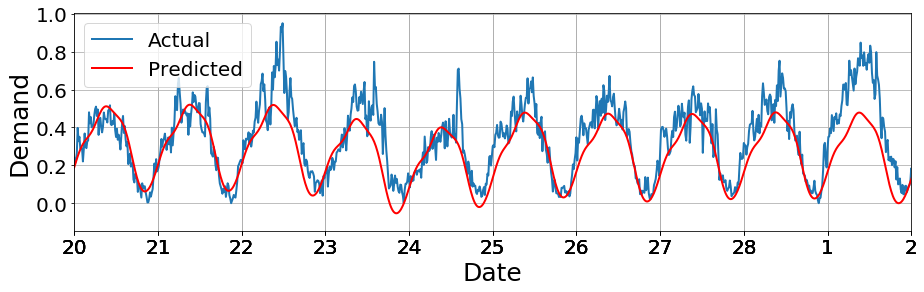

In [0]:
# check one location's forecast

location = '(-5.38055419921875, 90.8624267578125)'
plt_actual = pd.DataFrame(y_actual[location], index=df_test.index)

plot_forecast(plt_actual, y_pred[location], 
              title = location+' - Actual vs Forecast', 
              xlabel = 'Date', figsize=(15, 4))

print('RMSE: {:.5f}'.format(rmses[location]))
print('RMSE/mean(daily): {:.5%}'.format(per_err[location]))

# 7b. Predicting demand of each location using FBProphet (with Additional Regressors)

Here the regressors used were derived from the average hourly demand for each day of the week

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1725: UserWarning:

Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning:


The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.



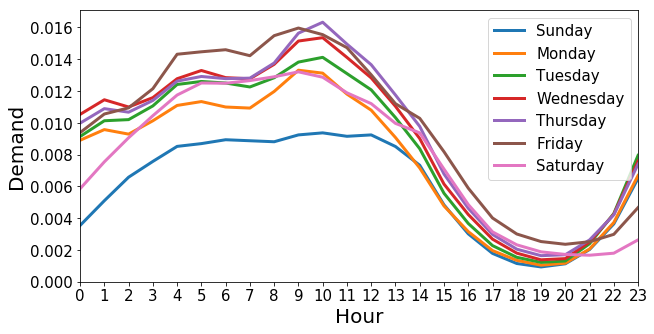

In [0]:
plot_days(df_day)

In [0]:
def add_lunch_rush(ds):
    """Returns a 1 if provided `ds` date is within 
    the defined nightlife hours. Otherwise returns
    a 0. Nightlife hours are defined as:
    * Thu 10 PM to Fri 1 AM
    * Fri 10 PM to Sat 2 AM
    * Sat 10 PM to Sun 2 AM"""
    date = pd.to_datetime(ds)
    if (date.weekday() < 6) & (date.hour <= 12) & (date.hour >= 9):
      return 1
    else:
      return 0

In [0]:
def add_nighttime_rush(ds):
    """Returns a 1 if provided `ds` date is within 
    the defined nightlife hours. Otherwise returns
    a 0. Nightlife hours are defined as:
    * 12 AM to 2 AM Monday to Friday"""
    date = pd.to_datetime(ds)
    if (date.weekday() < 5) & (date.hour < 3):
      return 1
    else:
        return 0

In [0]:
%%capture --no-stdout --no-display
y_pred_nt = {}
rmses_nt = {}
per_err_nt = {}
fc_pd = 1056
num_neighborhoods = len(df_train.columns)

# initialize prophet with a random neighborhood
m = Prophet(yearly_seasonality=False)
m.fit(get_prophet_df('(-5.35308837890625, 90.8184814453125)', df_train))

for i, n in enumerate(df_train.columns):
    
    print('{:>3}/{}'.format(i+1, num_neighborhoods), 
          n, ' - starting', end=', ')
    
    # create prediction df
    pred_df = get_prophet_df(n, df_train)
    pred_df['night_life'] = pred_df['ds'].apply(add_nighttime_rush)
    pred_df['lunch_time'] = pred_df['ds'].apply(add_lunch_rush)
    future_df = m.make_future_dataframe(periods=fc_pd, freq='15Min')
    future_df['night_life'] = future_df['ds'].apply(add_nighttime_rush)
    future_df['lunch_time'] = future_df['ds'].apply(add_lunch_rush)
    
    # forecast
    print('forecasting', end=', ')
    pred = prophet_forecast(n, pred_df, fc_pd, 
                            extra_reg=True, 
                            extra_reg_names=['night_life','lunch_time'],
                            future_df=future_df)
    y_pred_nt[n] = list(pred.yhat)
    
    # accuracy metrics
    print('calculating RMSE', end='\n')
    rmses_nt[n] = rmse(y_actual[n], y_pred_nt[n], print_val=False)
    per_err_nt[n] = percent_error(y_actual[n], y_pred_nt[n], print_val=False)

  1/100 (-5.35308837890625, 90.8184814453125)  - starting, forecasting, calculating RMSE
  2/100 (-5.34210205078125, 90.8404541015625)  - starting, forecasting, calculating RMSE
  3/100 (-5.32012939453125, 90.6866455078125)  - starting, forecasting, calculating RMSE
  4/100 (-5.32562255859375, 90.6866455078125)  - starting, forecasting, calculating RMSE
  5/100 (-5.31463623046875, 90.6536865234375)  - starting, forecasting, calculating RMSE
  6/100 (-5.33111572265625, 90.6756591796875)  - starting, forecasting, calculating RMSE
  7/100 (-5.32012939453125, 90.6536865234375)  - starting, forecasting, calculating RMSE
  8/100 (-5.45745849609375, 90.6866455078125)  - starting, forecasting, calculating RMSE
  9/100 (-5.36407470703125, 90.8184814453125)  - starting, forecasting, calculating RMSE
 10/100 (-5.35858154296875, 90.8184814453125)  - starting, forecasting, calculating RMSE
 11/100 (-5.35858154296875, 90.8074951171875)  - starting, forecasting, calculating RMSE
 12/100 (-5.347595214

In [0]:
print('Total RMSE: Prophet Model (with day and night rush hours)')
print('{:.5f}'.format(np.sum(list(rmses_nt.values()))))

Total RMSE: Prophet Model (with day and night rush hours)
13.66590


RMSE: 0.12816
RMSE/mean(daily): 37.20786%


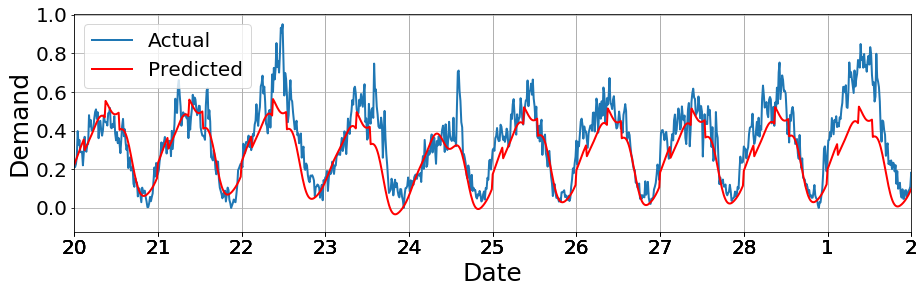

In [0]:
# we'll check the same forecast again

plt_actual = pd.DataFrame(y_actual[location], index=df_test.index)

plot_forecast(plt_actual, y_pred_nt[location], 
              title = location+' - Actual vs Forecast', 
              xlabel = 'Date', figsize=(15, 4))

print('RMSE: {:.5f}'.format(rmses_nt[location]))
print('RMSE/mean(daily): {:.5%}'.format(per_err_nt[location]))

# 7c. Using Holt-Winters Model to Predict Demand for each location

## Initialize Functions

In [0]:
def get_df(location, df):
    '''Returns a dataframe for a particular neighborhood
    in the format needed by prophet'''
    
    rdf = pd.DataFrame(df[location])
    rdf['Timestamp'] = rdf.index
    rdf['demand'] = rdf[location]
    rdf.reset_index(drop=True, inplace=True)
    rdf.drop(labels=[location], axis=1, inplace=True)
    rdf.fillna(value=0)
    
    return rdf

In [0]:
df_results = pd.DataFrame()
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

def hw_forecast(location, fit_df, fc_pd):    
    
    # fit
    model = ExponentialSmoothing(np.asarray(fit_df[location]),seasonal_periods=672,seasonal='add')
    model_fit = model.fit()
    
    # forecast
    df_results[location] = model_fit.forecast(fc_pd)
    
    # Make dataframe
    #pred = pd.DataFrame(prediction)
    
    return df_results

In [0]:
%%capture --no-stdout --no-display
y_actual_hw = {}
y_pred_hw = {}
rmses_hw = {}
per_err_hw = {}
fc_pd = len(df_test)
num_locs = len(df_train.columns)

for i, n in enumerate(df_train.columns):
    
    print('{:>3}/{}'.format(i+1, num_locs), 
          n, ' - starting', end=', ')
    
    # actual uber pickups
    actual = df_test[:fc_pd][n]
    actual.fillna(value=0, inplace=True)
    y_actual_hw[n] = list(actual)
    
    # prediction values
    print('forecasting', end=', ')
    pred = hw_forecast(n, df_train, fc_pd)
    y_pred_hw[n] = pred[n].values
    
    # accuracy metrics
    print('calculating RMSE', end='\n')
    rmses_hw[n] = rmse(y_actual_hw[n], y_pred_hw[n], print_val=False)
    per_err_hw[n] = percent_error(y_actual_hw[n], y_pred_hw[n], print_val=False)

  1/100 (-5.35308837890625, 90.8184814453125)  - starting, forecasting, calculating RMSE
  2/100 (-5.34210205078125, 90.8404541015625)  - starting, forecasting, calculating RMSE
  3/100 (-5.32012939453125, 90.6866455078125)  - starting, forecasting, calculating RMSE
  4/100 (-5.32562255859375, 90.6866455078125)  - starting, forecasting, calculating RMSE
  5/100 (-5.31463623046875, 90.6536865234375)  - starting, forecasting, calculating RMSE
  6/100 (-5.33111572265625, 90.6756591796875)  - starting, forecasting, calculating RMSE
  7/100 (-5.32012939453125, 90.6536865234375)  - starting, forecasting, calculating RMSE
  8/100 (-5.45745849609375, 90.6866455078125)  - starting, forecasting, calculating RMSE
  9/100 (-5.36407470703125, 90.8184814453125)  - starting, forecasting, calculating RMSE
 10/100 (-5.35858154296875, 90.8184814453125)  - starting, forecasting, calculating RMSE
 11/100 (-5.35858154296875, 90.8074951171875)  - starting, forecasting, calculating RMSE
 12/100 (-5.347595214

In [0]:
print('Total RMSE: Holt-Winters')
print('{:.5f}'.format(np.sum(list(rmses_hw.values()))))

Total RMSE: Holt-Winters
23.34487


RMSE: 0.11483
RMSE/mean(daily): 33.33926%


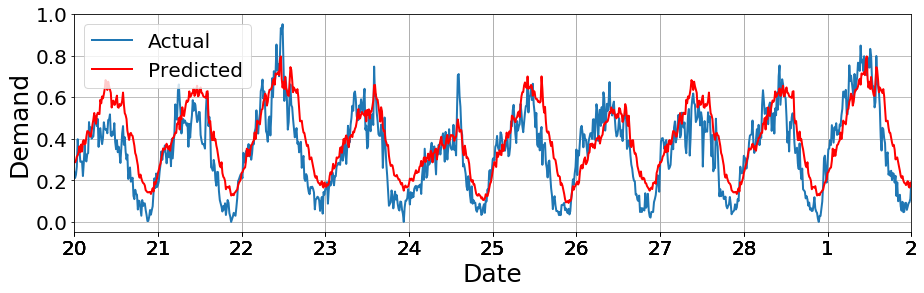

In [0]:
# we'll check the same forecast again

plt_actual = pd.DataFrame(y_actual_hw[location], index=df_test.index)

plot_forecast(plt_actual, y_pred_hw[location], 
              title = location+' - Actual vs Forecast', 
              xlabel = 'Date', figsize=(15, 4))

print('RMSE: {:.5f}'.format(rmses_hw[location]))
print('RMSE/mean(daily): {:.5%}'.format(per_err_hw[location]))

# 8. Testing SARIMAX

In [0]:
!pip install pyramid-arima

     |████████████████████████████████| 604kB 5.2MB/s 


## Finding hyperparameters

I attempted to find the hyperparameters for an ARIMA model by using auto_arima. However, the runtime for a single model takes more than 15 minutes, which means we cannot calculate the surge pricing* in time.

I think if we use cloud computing this would probably more possible. But I am not familiar with such technology yet so I decided to omit the variations of ARIMA models (ARIMA, and SARIMAX).

*I am assuming the pricing for grab ride-hailing services is done every 15 minutes since their data set has 15 minute intervals  


In [0]:
df_arima = df_ave.set_index('Timestamp')

In [0]:
from pyramid.arima import auto_arima
stepwise_model = auto_arima(df_arima, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=672,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

# 9. Comparing predictions for different locations

From looping all top 100 locations with highest average demand, I was able to notice that the Holt-Winters model had the highest RMSE. 

Total RMSE for 100 locations:
<br>Prophet Model: 13.87675
<br>Prophet Model (with day and night rush hours): 13.66590
<br>Holt-Winters: 23.34487

This was strange since Holt-Winters can seem to capture the spikes in demand within the day from the single location that we plotted. So I decided to investigate more on the why this happened.

From this section, I discovered was that the Holt-Winters model does not perform well in predicting the travel demand of other locations. This might be caused by the trend that is not negligible in some locations. 

This error was caused by my assumption in the beginning that the minute increase in trend applied to all locations. To resolve this problem, we must observe the trend of every location and integrate it into the Holt-Winters model.

In [0]:
df_top.iloc[99]

geohash6                                    qp03zt
demand                                    0.193797
lat_long     (-5.28717041015625, 90.6866455078125)
latitude                                  -5.28717
longitude                                  90.6866
Name: 99, dtype: object

## Location with the highest average demand (-5.35308837890625, 90.8184814453125)

In [0]:
loc_top = '(-5.35308837890625, 90.8184814453125)'

RMSE: 0.15544
RMSE/mean(daily): 17.18488%


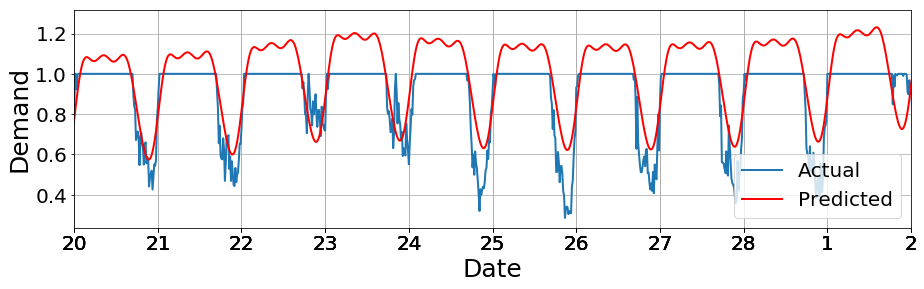

In [0]:
plt_actual = pd.DataFrame(y_actual[loc_top], index=df_test.index)

plot_forecast(plt_actual, y_pred[loc_top], 
              title = location+' - Actual vs Forecast', 
              xlabel = 'Date', figsize=(15, 4))

print('RMSE: {:.5f}'.format(rmses[loc_top]))
print('RMSE/mean(daily): {:.5%}'.format(per_err[loc_top]))

RMSE: 0.15472
RMSE/mean(daily): 17.10458%


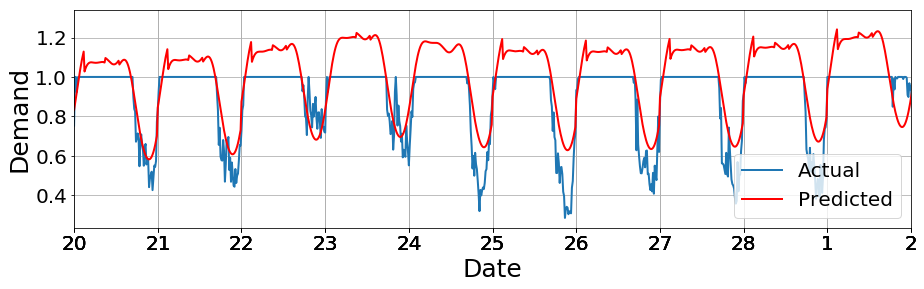

In [0]:
# we'll check the same forecast again

plt_actual = pd.DataFrame(y_actual[loc_top], index=df_test.index)

plot_forecast(plt_actual, y_pred_nt[loc_top], 
              title = location+' - Actual vs Forecast', 
              xlabel = 'Date', figsize=(15, 4))

print('RMSE: {:.5f}'.format(rmses_nt[loc_top]))
print('RMSE/mean(daily): {:.5%}'.format(per_err_nt[loc_top]))

RMSE: 0.17058
RMSE/mean(daily): 18.85865%


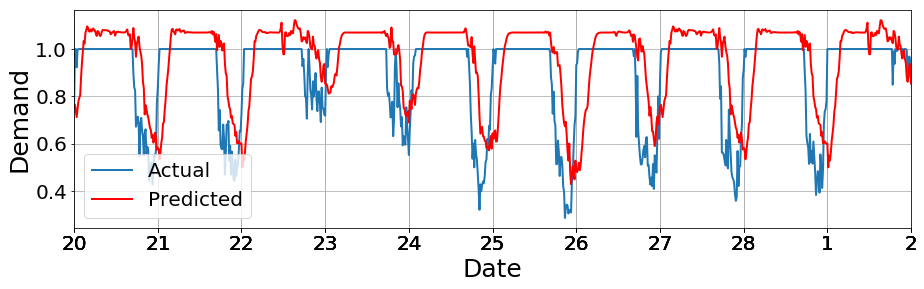

In [0]:
# we'll check the same forecast again

plt_actual = pd.DataFrame(y_actual_hw[loc_top], index=df_test.index)

plot_forecast(plt_actual, y_pred_hw[loc_top], 
              title = location+' - Actual vs Forecast', 
              xlabel = 'Date', figsize=(15, 4))

print('RMSE: {:.5f}'.format(rmses_hw[loc_top]))
print('RMSE/mean(daily): {:.5%}'.format(per_err_hw[loc_top]))

## Location for average demand ()

In [0]:
loc_mid = '(-5.33660888671875, 90.6866455078125)'

RMSE: 0.12003
RMSE/mean(daily): 44.04212%


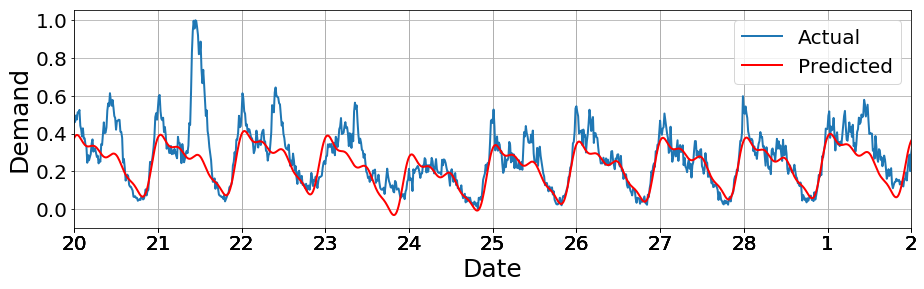

In [0]:
plt_actual = pd.DataFrame(y_actual[loc_mid], index=df_test.index)

plot_forecast(plt_actual, y_pred[loc_mid], 
              title = location+' - Actual vs Forecast', 
              xlabel = 'Date', figsize=(15, 4))

print('RMSE: {:.5f}'.format(rmses[loc_mid]))
print('RMSE/mean(daily): {:.5%}'.format(per_err[loc_mid]))

RMSE: 0.11721
RMSE/mean(daily): 43.00629%


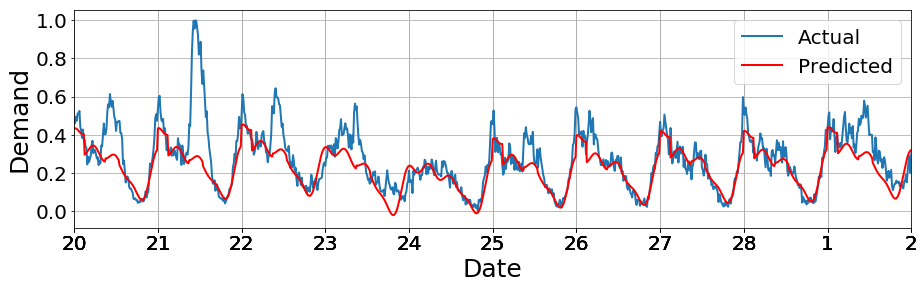

In [0]:
# we'll check the same forecast again

plt_actual = pd.DataFrame(y_actual[loc_mid], index=df_test.index)

plot_forecast(plt_actual, y_pred_nt[loc_mid], 
              title = location+' - Actual vs Forecast', 
              xlabel = 'Date', figsize=(15, 4))

print('RMSE: {:.5f}'.format(rmses_nt[loc_mid]))
print('RMSE/mean(daily): {:.5%}'.format(per_err_nt[loc_mid]))

RMSE: 0.24886
RMSE/mean(daily): 91.31593%


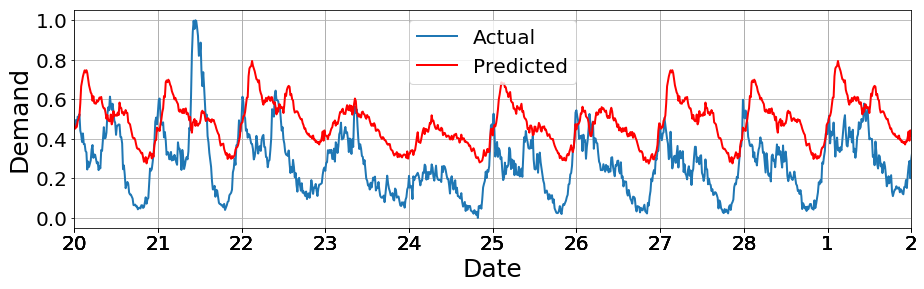

In [0]:
# we'll check the same forecast again

plt_actual = pd.DataFrame(y_actual_hw[loc_mid], index=df_test.index)

plot_forecast(plt_actual, y_pred_hw[loc_mid], 
              title = location+' - Actual vs Forecast', 
              xlabel = 'Date', figsize=(15, 4))

print('RMSE: {:.5f}'.format(rmses_hw[loc_mid]))
print('RMSE/mean(daily): {:.5%}'.format(per_err_hw[loc_mid]))

## Location with low demand (-5.28717041015625, 90.6866455078125)

In [0]:
loc_low = '(-5.28717041015625, 90.6866455078125)'

RMSE: 0.07012
RMSE/mean(daily): 33.07513%


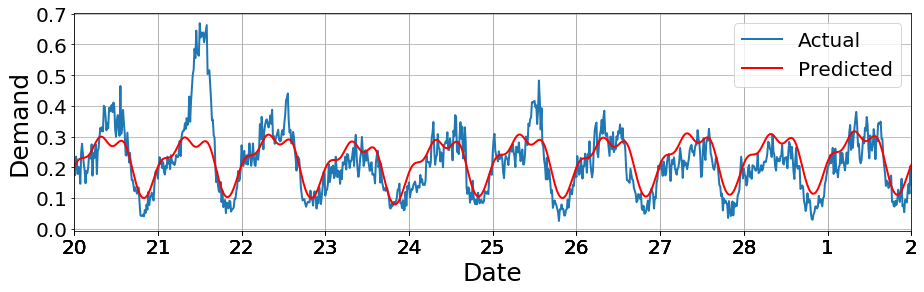

In [0]:
plt_actual = pd.DataFrame(y_actual[loc_low], index=df_test.index)

plot_forecast(plt_actual, y_pred[loc_low], 
              title = location+' - Actual vs Forecast', 
              xlabel = 'Date', figsize=(15, 4))

print('RMSE: {:.5f}'.format(rmses[loc_low]))
print('RMSE/mean(daily): {:.5%}'.format(per_err[loc_low]))

RMSE: 0.07014
RMSE/mean(daily): 33.08447%


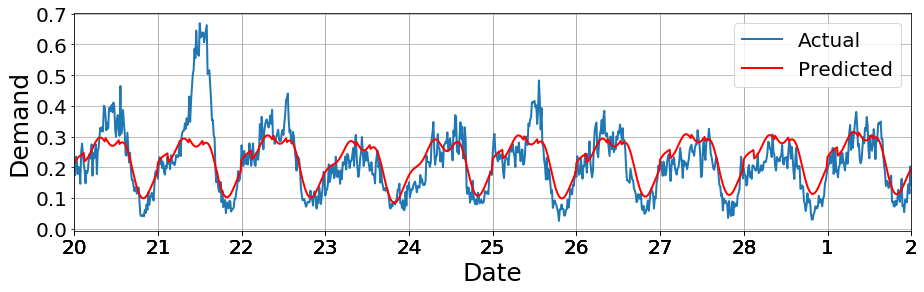

In [0]:
# we'll check the same forecast again

plt_actual = pd.DataFrame(y_actual[loc_low], index=df_test.index)

plot_forecast(plt_actual, y_pred_nt[loc_low], 
              title = location+' - Actual vs Forecast', 
              xlabel = 'Date', figsize=(15, 4))

print('RMSE: {:.5f}'.format(rmses_nt[loc_low]))
print('RMSE/mean(daily): {:.5%}'.format(per_err_nt[loc_low]))

RMSE: 0.07026
RMSE/mean(daily): 33.14256%


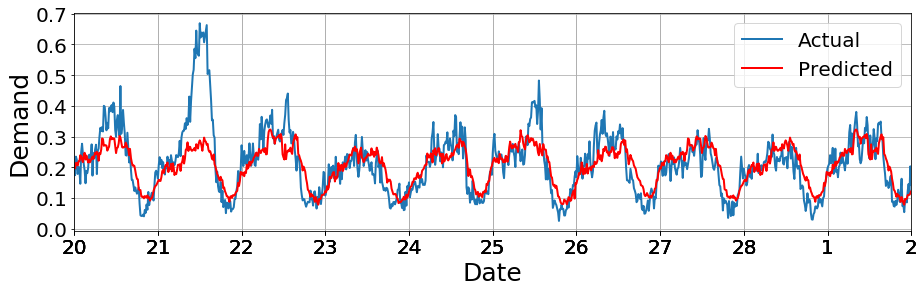

In [0]:
# we'll check the same forecast again

plt_actual = pd.DataFrame(y_actual_hw[loc_low], index=df_test.index)

plot_forecast(plt_actual, y_pred_hw[loc_low], 
              title = location+' - Actual vs Forecast', 
              xlabel = 'Date', figsize=(15, 4))

print('RMSE: {:.5f}'.format(rmses_hw[loc_low]))
print('RMSE/mean(daily): {:.5%}'.format(per_err_hw[loc_low]))

# 10. Conclusion

*If you were able to watch my presentation on Eskwelabs Demo Day, the results have changed since then with regards to the generalizability of the model.

From executing this project, I have come up with these main insights:

1. Travel demand for Grab generally revolves around specific areas
2. Travel demand is also dependent on the time of the day and the day of the week.
3. The models I have constructed are NOT yet generalizable for each location because it does not take into account the trend for each location 

## Unresolved Questions

Some unresolved questions are the following:

1. How did Grab calculate the travel demand for each location?
  - It is intriguing becuase some locations have plateau at 1 for almost the whole day.
  - And knowing how they calculated this could probably change the way we could look at the data set
2. Could the SARIMAX model have worked?
 - Although I was not able to run it, it might have been a good option becuase it considered seasonality and additional regressors on top of the ARIMA model

# Resources

Codes were derived from these two sources:

1. Forecasting Uber Demand in NYC
https://medium.com/@Vishwacorp/timeseries-forecasting-uber-demand-in-nyc-54dcfcdfd1f9
2. Time Series Methods Tutorial
https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/